## 데이터 핸들링 관련 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
# import statsmodels.api as sm
import xgboost as xgb
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
import time

import warnings
# import the_module_that_warns
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from datetime import datetime
from datetime import date

# 상한/하한 n번째로 구하기 위함
import heapq

company_list = pd.read_excel('./company_list.xlsx')
company_list['종목코드'] = company_list['종목코드'].astype(str).str.zfill(6)

## 주식종목 선택

In [2]:
stock_name = str(input('회사(주식)이름을 입력해주세요 :'))

회사(주식)이름을 입력해주세요 :아모레퍼시픽


## 일일종가 데이터 크롤링

In [3]:
ts = time.time()
""" 라이브러리 호출 """
import urllib
from bs4 import BeautifulSoup
import requests
from datetime import datetime
""" 회사코드 및 조회기간 설정 """
symbol = company_list[company_list['회사명'] == stock_name]['종목코드'].values[0]
startTime = (datetime.today()-timedelta(days=1)).strftime('%Y%m%d')
count = str(1000)

""" url 설정 """
url = 'https://fchart.stock.naver.com/sise.nhn?symbol={}&timeframe=day&startTime={}&count={}&requestType=2'.format(symbol , startTime, count)

""" 크롤링 & 전처리 """
r = requests.get(url)
html = r.content
soup = BeautifulSoup(html, 'html.parser')
tr = soup.find_all('item') 
cols = ['일자' , '시가' , '고가' , '저가' , '종가' , '거래량']
list = []
for i in range(0, len(soup.find_all('item'))):
    list.append(re.search(r'"(.*)"', str(tr[i])).group(1).split('|'))
df = pd.DataFrame(list , columns=cols )
df['일자'] = pd.to_datetime(df['일자'].str[:4]+'-'+df['일자'].str[4:6]+'-'+df['일자'].str[6:])
df.set_index(df['일자'], inplace=True)
df = df.drop(columns = '일자')
print('작동소요시간 :' , round(time.time()-ts ,1) , '초')

작동소요시간 : 0.5 초


In [4]:
df.to_csv('./saving_test.csv', encoding='utf-8')
data = pd.read_csv('./saving_test.csv')  # 데이터 로딩

In [5]:
data = data.iloc[:,1:6]
# data.iloc[:,[4]]

In [6]:
data

,시가,고가,저가,종가,거래량
0,375500,378500,369000,377500,130795
1,377000,380000,372500,379000,111395
2,375000,376000,366000,371500,201061
3,367000,371000,355000,358500,209966
4,361500,365500,355500,357000,170560
5,359000,366500,358000,366500,155875
6,363000,365000,356000,357500,156133
7,364000,369500,357000,367000,181845
8,369500,379000,367500,376000,140581
9,376000,391500,375000,390500,245999


In [7]:
xy = np.array(data, dtype=np.float32)
x_data = xy[:, 1:-1]
# y_data = xy[:, [3]]

In [8]:
x_data

array([[378500., 369000., 377500.],
       [380000., 372500., 379000.],
       [376000., 366000., 371500.],
       ...,
       [182500., 174500., 177500.],
       [182000., 174000., 178000.],
       [185000., 167500., 172000.]], dtype=float32)

## Prophet

- Prophet 알고리즘 삽입을 위한 형태 다듬기

In [9]:
df_prophet = df.copy()
df_prophet.index.name = 'ds'
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet[['ds', '종가']]
df_prophet.columns = ['ds' , 'y']

# 지울 것. PI 장표그릴때 그래프 필요해서 작업한 내용임
df_prophet = df_prophet.iloc[ :-30 , :]

- Prophet 알고리즘 Main 동작 코드

In [10]:
ts = time.time()
####################################################################
""" 1) Prophet 함수를 불러옴 """
from fbprophet import Prophet

""" 2) Prophet 함수를 m으로 받음 """
m = Prophet()

""" 3) m에 준비한 학습데이터를 적합(fit)하여 학습시킴 """
m.fit(df_prophet)

""" 4) 예측할 미래구간 길이를 지정함 """
forecast = m.make_future_dataframe(1000)

""" 5) predict 명령어로 예측을 수행시킴 """
forecast = m.predict(forecast)
####################################################################
print('작동소요시간 :' , round(time.time()-ts ,1) , '초')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


작동소요시간 : 5.2 초


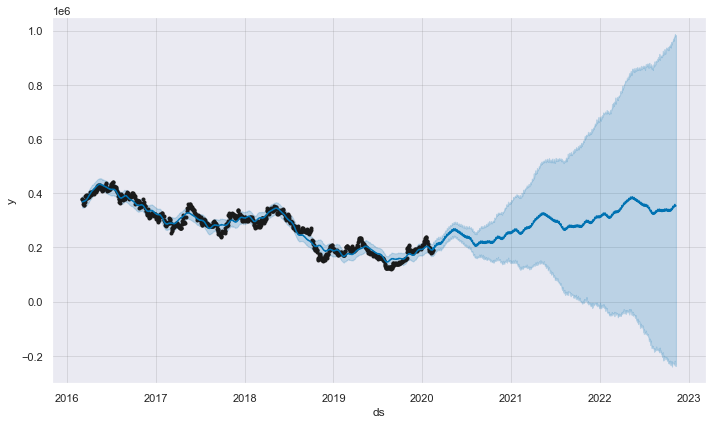

In [11]:
fig1 = m.plot(forecast)

- 결과데이터 다듬기

In [12]:
train = df_prophet.copy()
target = forecast[forecast['ds'] > df_prophet['ds'].max()]
train['y'] = train['y'].astype('int64')
target['yhat'] = target['yhat'].astype('int64')
target['yhat_max'] = target['yhat'].max()
target['yhat_min'] = target['yhat'].min()

- 시각화

In [14]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

total_trend = []
total_trend.append(go.Scatter( x = train['ds'] , y = train['y'] , name = '실제가격'))
total_trend.append(go.Scatter( x = target['ds'] , y = target['yhat'] , name = '예상가격'))
total_trend.append(go.Scatter( x = target['ds'] , y = target['yhat_max'] , name = '예상 최고가격'))
total_trend.append(go.Scatter( x = target['ds'] , y = target['yhat_min'] , name = '예상 최저가격'))
layout = go.Layout( title = '{}'.format('Prophet '+stock_name+' 주가예측') , xaxis = dict(title = '날짜') , yaxis = dict(title = '종가')) 
fig = go.Figure(data = total_trend  , layout = layout)
iplot(fig)

## Xgboost

- Xgboost 알고리즘 삽입을 위한 형태 다듬기

In [15]:
import datetime

def create_features(df, label=None):
    """
    Create time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X,y
    return X

# 예측대상 만들어내기
date1 = datetime.datetime.today().strftime('%Y-%m-%d')
date2 = (datetime.datetime.today() + timedelta(days=365)).strftime('%Y-%m-%d')
date_range = pd.date_range(date1, date2)
df_xgboost_target = pd.DataFrame([])
df_xgboost_target['date'] = date_range
df_xgboost_target.set_index('date' , inplace=True)
df_xgboost_target['종가'] = ''

df_xgboost = df.copy()
df_xgboost.index.name = 'date'
df_xgboost = df_xgboost[['종가']].astype('int64')
X_features, y_label = create_features(df_xgboost, label='종가')
X_forecast_features, y_forecast_label = create_features(df_xgboost_target, label='종가')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

- Xgboost Main 동작 코드

In [16]:
ts = time.time()
####################################################################
""" 1) xgboost 라이브러리를 불러옴 """
import xgboost as xgb

""" 2) xgboost 라이브러리에서 예측을 담당하는 Regressor 함수를 불러오고, 예측대상구간을 지정시킴 """
reg = xgb.XGBRegressor(n_estimators=365)

""" 3) 미리 다듬어둔 데이터를, 변수값(x) , 예측대상지표(y)로 구분하여 학습시킴 """
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

""" 4) predict 명령어로 예측을 수행시킴 """
df_xgboost_target['종가'] = reg.predict(X_forecast_features)
####################################################################
print('작동소요시간 :' , round(time.time()-ts ,1) , '초')

[0]	validation_0-rmse:200590.35938	validation_1-rmse:202316.82812
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:141719.79688	validation_1-rmse:142858.32812
[2]	validation_0-rmse:100418.69531	validation_1-rmse:101640.96094
[3]	validation_0-rmse:71481.18750	validation_1-rmse:72599.88281
[4]	validation_0-rmse:51088.28125	validation_1-rmse:52420.65625
[5]	validation_0-rmse:36754.53906	validation_1-rmse:38246.97656
[6]	validation_0-rmse:26581.01562	validation_1-rmse:27886.44727
[7]	validation_0-rmse:19460.48047	validation_1-rmse:20560.54492
[8]	validation_0-rmse:14671.73926	validation_1-rmse:15924.03320
[9]	validation_0-rmse:11328.35742	validation_1-rmse:12809.02734
[10]	validation_0-rmse:9195.69141	validation_1-rmse:11074.40918
[11]	validation_0-rmse:7530.39648	validation_1-rmse:9932.90137
[12]	validation_0-rmse:6612.58789	validation_1-rmse:9198.22559
[13]	

In [17]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2018-03-29,3,1,3,2018,88,29,13
2019-12-20,4,4,12,2019,354,20,51
2016-07-01,4,3,7,2016,183,1,26
2019-12-23,0,4,12,2019,357,23,52
2016-10-14,4,4,10,2016,288,14,41
2016-07-13,2,3,7,2016,195,13,28
2019-01-17,3,1,1,2019,17,17,3
2017-02-02,3,1,2,2017,33,2,5
2017-07-03,0,3,7,2017,184,3,27


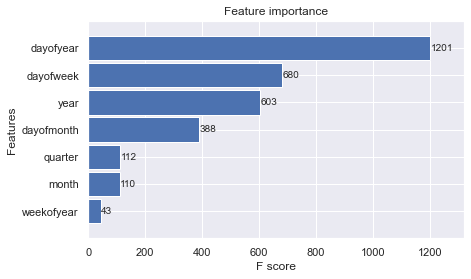

In [18]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(reg, height=0.9)

- 결과데이터 다듬기

In [19]:
df_xgboost_target['종가_max'] = df_xgboost_target['종가'].max()
df_xgboost_target['종가_min'] = df_xgboost_target['종가'].min()

- 시각화

In [20]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

total_trend = []
total_trend.append(go.Scatter( x = df_xgboost.index , y = df_xgboost['종가'] , name = '실제가격'))
total_trend.append(go.Scatter( x = df_xgboost_target.index , y = df_xgboost_target['종가'] , name = '예상가격'))
total_trend.append(go.Scatter( x = df_xgboost_target.index , y = df_xgboost_target['종가_max'] , name = '예상최대가격'))
total_trend.append(go.Scatter( x = df_xgboost_target.index , y = df_xgboost_target['종가_min'] , name = '예상최저가격'))
layout = go.Layout( title = '{}'.format('XGBoost '+stock_name+' 주가예측') , xaxis = dict(title = '날짜') , yaxis = dict(title = '종가')) 
fig = go.Figure(data = total_trend  , layout = layout)
iplot(fig)

In [21]:
print('--------------------------------------------------')
print('--------------- 머신러닝 예상 주가 ---------------')
print('--------------------------------------------------')
print('■ Prophet {} 주가예측'.format(stock_name))
print('향후 1년내 최대가 :' , round(target['yhat'].max()/10000, 1) , '만원')
print('향후 1년내 최저가 :' , round(target['yhat'].min()/10000, 1) , '만원')
print('--------------------------------------------------')
print('■ Xgboost {} 주가예측'.format(stock_name))
print('향후 1년내 최대가 :' , round(df_xgboost_target['종가'].max()/10000, 1) , '만원')
print('향후 1년내 최저가 :' , round(df_xgboost_target['종가'].min()/10000, 1) , '만원')

--------------------------------------------------
--------------- 머신러닝 예상 주가 ---------------
--------------------------------------------------
■ Prophet 아모레퍼시픽 주가예측
향후 1년내 최대가 : 38.6 만원
향후 1년내 최저가 : 19.4 만원
--------------------------------------------------
■ Xgboost 아모레퍼시픽 주가예측
향후 1년내 최대가 : 23.5 만원
향후 1년내 최저가 : 12.3 만원
